# Comparing means

In performance engineering, we're often worried about the difference of means of two variables.
We'll illustrate with generated data how this is easier to measure in a bayesian setting.

In [1]:
using Distributions

In [23]:
using StatsPlots

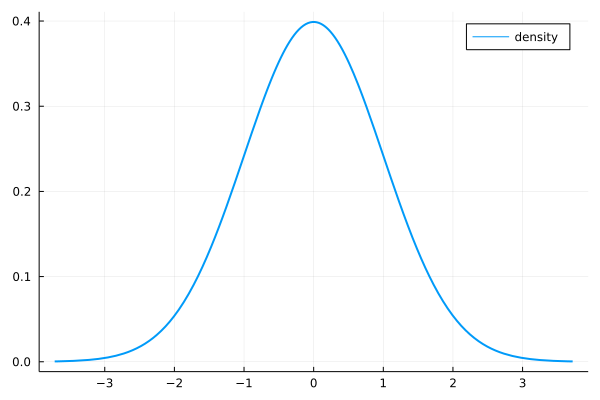

In [24]:
p = plot(Normal(), label="density", linewidth=2.0)

In [25]:
savefig(p, "figures/normal_distribution.pdf")

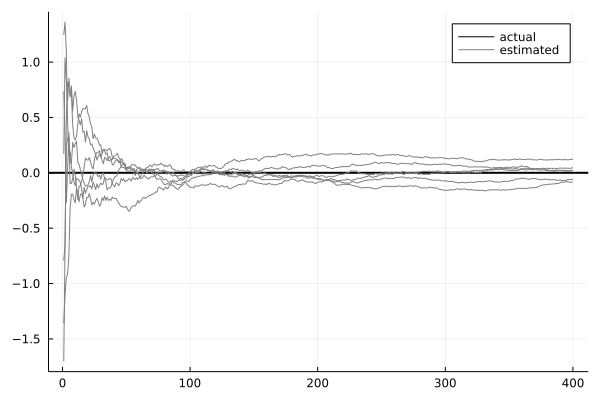

In [50]:
# Showing that the mean fluctuates
# We'll compare the theoretical 

p = hline([0.0], label="actual", linewidth=2,
    color="black")

for n in 1:6
    means = []
    samples = []
    for i in 1:400
        x = rand(Normal())
        append!(samples,[x])

        append!(means, [mean(samples)])
    end
    if n == 1
        label = "estimated"
    else
        label = missing
    end
    
    plot!(means, label=label,
          linewidth=1, color="gray")
end

p

In [51]:
savefig(p, "figures/mean_error.pdf")

In [42]:
samples_a = rand(Normal(mu_a, sigma_a), n_a)
samples_b = rand(Normal(mu_b, sigma_b), n_b)

20-element Vector{Float64}:
  8.401637723874899
 13.162290371706694
 14.52269840754997
 14.680290305031924
 12.719814544927225
 10.92957070419488
 11.625222337607516
 14.572226426037398
 14.4065301612651
 12.178954793665907
 10.306673425246967
 12.619390465443955
 16.054288108368098
 14.559106511755278
 13.499231477170312
 11.295868379458689
 11.82037950839809
 12.110758148670016
 17.004275465489947
 16.24140006228325

In [43]:
mu_a = 14.0
mu_b = 13.0

true_delta = mu_b - mu_a

sigma_a = 4.0
sigma_b = 2.0

n_a = 30
n_b = 20

20

In [44]:
using VegaLite

In [45]:
using DataFrames

In [46]:
df_samples = vcat(DataFrame("label"=>repeat(["A"], n_a), "value"=>samples_a),
                  DataFrame("label"=>repeat(["B"], n_b), "value"=>samples_b));

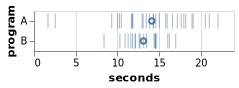

In [47]:
plot_a_b_samples = df_samples |>
    @vlplot(
    layer=[
        {mark={type=:tick, opacity=0.5},
         x={field=:value, title="seconds"},
         y={field=:label, title="program"}},
        {mark={type=:point},
         x="mean(value)",
         y=:label}
    ]
)

In [48]:
save("figures/samples_a_b.svg", plot_a_b_samples)

# Confidence intervals

In [37]:
# We use this to compute means with confidence intervals. Lol
using GLM

In [38]:
lm1 = lm(@formula(value ~ label), df_samples)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

value ~ 1 + label

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  14.9557     0.525467  28.46    <1e-30   13.8992    16.0122
label: B     -1.34213    0.830837  -1.62    0.1128   -3.01264    0.32838
────────────────────────────────────────────────────────────────────────

In [40]:
minmax_a = confint(lm1)[1,:]

minmax_b = confint(lm1)[2,:] .+ coef(lm1)[1] 

2-element Vector{Float64}:
 11.943060840585359
 15.284078883546993

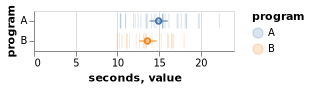

In [63]:
plot_a_b_samples = df_samples |>
    @vlplot(
    color={field="label", title="program"},
    layer=[
        {mark={type=:tick, opacity=0.2},
         x={field=:value, title="seconds"},
         y={field=:label, title="program"}},
        {mark=:point, x="mean(value)", y="label"},
        {mark={type=:errorbar, extent="ci"},
         x=:value, y=:label},
        # {mark={type=:rule, opacity=0.1},
        #  x={datum=minmax_a[1]},
        #  y={datum="A"},
        #  x2={datum=minmax_a[2]}},
        # {mark={type=:rule, opacity=0.1},
        #  x={datum=minmax_b[1]},
        #  y={datum="B"},
        #  x2={datum=minmax_b[2]}},
        #  {mark={type=:rule, strokeWidth=3, strokeDash=[4,4]}, x=[mu_a, mu_b], color=["A", "B"]}
    ]
)

In [12]:
using Turing

In [13]:
@model function means_model(As, Bs)
    mu_a ~ Normal(10.0, 5.0)
    mu_b ~ Normal(10.0, 5.0)
    
    sigma_a ~ Exponential(1.0)
    sigma_b ~ Exponential(1.0)
    
    for i in eachindex(As)
        As[i] ~ Normal(mu_a, sigma_a) 
    end
    
    for i in eachindex(Bs)
        Bs[i] ~ Normal(mu_b, sigma_b)
    end
    
    return mu_b - mu_a
end

means_model (generic function with 2 methods)

In [14]:
model = means_model(samples_a, samples_b)
chain = sample(model, NUTS(0.65), 5000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /home/noric/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /home/noric/.julia/packages/AdvancedHMC/51xgc/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/noric/.julia/packages/Turing/CVKOh/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 15.15 seconds
Compute duration  = 15.15 seconds
parameters        = mu_a, mu_b, sigma_a, sigma_b
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        mu_a   15.7881    0.8024     0.0113    0.0108   6624.7309    0.9999    ⋯
        mu_b   13.1619    0.4382     0.0062    0.0062   5496.2249    1.0004    ⋯
     sigma_a    3.6282    0.5632     0.0080    0.0095   4827.6711    0.9999    ⋯
     sigma_b    1.7045    0.3265     0.0046    0.0043   4676.8823    0.9998    ⋯
                                           

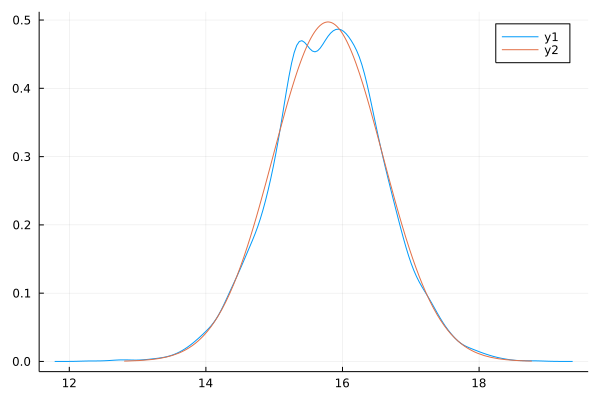

In [15]:
density(chain[:mu_a])
plot!(fit(Normal, chain[:mu_a]))

In [16]:
using DataFrames

In [17]:
df = DataFrame(chain)[!, chain.name_map.parameters] |> DataFrames.stack

20000×2 DataFrame
   Row │ variable  value    
       │ String    Float64  
───────┼────────────────────
     1 │ mu_a      16.6506
     2 │ mu_a      15.1589
     3 │ mu_a      16.1003
     4 │ mu_a      15.6303
     5 │ mu_a      16.7283
     6 │ mu_a      16.4938
     7 │ mu_a      17.3674
     8 │ mu_a      14.9878
     9 │ mu_a      16.239
    10 │ mu_a      14.5806
    11 │ mu_a      15.3858
   ⋮   │    ⋮         ⋮
 19991 │ sigma_b    1.25402
 19992 │ sigma_b    1.84702
 19993 │ sigma_b    2.57178
 19994 │ sigma_b    1.40019
 19995 │ sigma_b    1.60352
 19996 │ sigma_b    1.42799
 19997 │ sigma_b    1.42799
 19998 │ sigma_b    1.9905
 19999 │ sigma_b    1.41455
 20000 │ sigma_b    1.92474
          19979 rows omitted

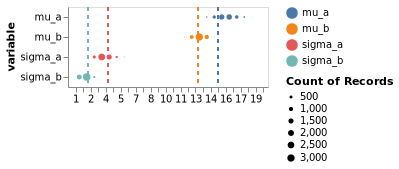

In [18]:
compact_plot_chain = df |>
    @vlplot(
        layer=[
            {mark={type=:circle}, 
             x={field=:value, bin={step=0.75}},
             size="count()",
             y={field=:variable, type=:ordinal},
             color=:variable},
            {mark={type=:rule, strokeDash=[4,4], strokeWidth=2},
             x=[mu_a, mu_b, sigma_a, sigma_b], 
             color=["mu_a", "mu_b", "sigma_a", "sigma_b"]},
        ])

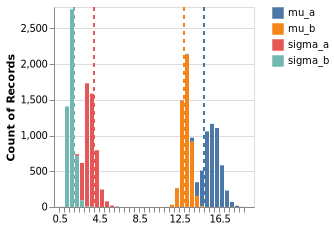

In [19]:
plot_chain = df |> 
    @vlplot(
    layer=[
        {mark={type=:bar},
         x={field=:value, type=:quantitative, bin={step=0.5}},
         y={aggregate=:count, stack=:true},
         color=:variable},
        {mark={type=:rule, strokeDash=[4,4], strokeWidth=2},
             x=[mu_a, mu_b, sigma_a, sigma_b], 
             color=["mu_a", "mu_b", "sigma_a", "sigma_b"]}
    ])

In [20]:
save("figures/plot_a_b_parameters.svg", plot_chain)

In [21]:
using GLM

In [42]:
using CSV

In [43]:
CSV.write("dataframe-means.csv", df_samples)

"dataframe-means.csv"

# Looking at the difference

We look at the difference between the means of the two distributions. First with a linear regression, and second, we use bayesian inference, and sompare the two.

In [27]:
using HypothesisTests

In [28]:
welch_test = UnequalVarianceTTest(samples_b, samples_a)

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          -2.76612
    95% confidence interval: (-4.693, -0.8392)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0065

Details:
    number of observations:   [15,20]
    t-statistic:              -2.9422084923055176
    degrees of freedom:       27.638466772805316
    empirical standard error: 0.9401509385904276


In [29]:
interval_diff = [confint(welch_test, level=0.95)[1], 
                 confint(welch_test, level=0.95)[2]]

2-element Vector{Float64}:
 -4.693067513393061
 -0.8391726377464579

In [30]:
# Getting the delta
deltas = generated_quantities(model, chain)

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

Excessive output truncated after 525048 bytes.┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL /home/noric/.julia/packages/DynamicPPL/R7VK9/src/varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian

5000×1 Matrix{Float64}:
 -3.1589640511990247
 -2.6513608313728056
 -2.171777180783007
 -2.3482599910771356
 -3.264917028201552
 -3.5280728059079447
 -4.373544141153271
 -1.5539226857230055
 -3.3861577095983026
 -1.6417143807167882
 -2.4113483306466996
 -2.502020650911634
 -1.0400719842700283
  ⋮
 -3.040953669418938
 -1.922420581679523
 -4.571158092192377
 -2.800606019359993
 -1.7200402801494779
 -2.363541547091705
 -3.0913479752823942
 -3.1954061117345915
 -3.1954061117345915
 -1.3663424953809518
 -4.176096696447866
 -3.574066802855148

In [42]:
deltas_df = vcat(DataFrame("delta"=>vec(deltas), "type"=>repeat(["posterior"], 5000)),
    DataFrame("delta"=>[true_delta], "type"=>["true value"]),
    DataFrame("delta"=>interval_diff, "type"=>repeat(["confidence interval"], 2)),
    DataFrame("delta"=>quantile(vec(deltas), [0.025, 0.975]), "type"=>repeat(["credible interval"], 2)))

5005×2 DataFrame
  Row │ delta     type                
      │ Float64   String              
──────┼───────────────────────────────
    1 │ -5.41736  posterior
    2 │ -5.23183  posterior
    3 │ -5.84605  posterior
    4 │ -3.50537  posterior
    5 │ -3.69203  posterior
    6 │ -3.04658  posterior
    7 │ -4.34357  posterior
    8 │ -4.61671  posterior
    9 │ -3.30408  posterior
   10 │ -2.20136  posterior
   11 │ -3.67321  posterior
  ⋮   │    ⋮               ⋮
 4996 │ -3.05145  posterior
 4997 │ -2.19144  posterior
 4998 │ -4.7589   posterior
 4999 │ -2.26805  posterior
 5000 │ -3.28353  posterior
 5001 │ -2.0      true value
 5002 │ -5.31827  confidence interval
 5003 │ -1.75036  confidence interval
 5004 │ -5.25508  credible interval
 5005 │ -1.77841  credible interval
                     4984 rows omitted

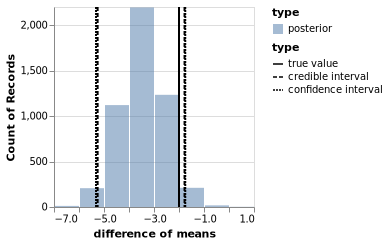

In [85]:
plot_differences = deltas_df |>
    @vlplot(
        legend=true,
        layer=[
            {mark={type=:bar, opacity=0.5},
             transform=[{filter="datum.type == 'posterior'"}],
             x={field=:delta, bin=true, title="difference of means"},
             y="count()",
             color="type",
             },
            {mark={type=:rule, strokeWidth=2.0},
             transform=[{filter="datum.type != 'posterior'"}],
             strokeDash={field=:type, scale={domain=["true value", "credible interval", "confidence interval"]}},
             x=:delta}
    ]
    )

Welch's t-test confidence interval is the right statistical tool, but we notice that the credible intervals are very close to the confidence interval. This is the case because the assumptions of Welch's t-test are respected: The means are normally distributed. 

In [86]:
save("figures/plot_difference_of_means.svg", plot_differences)

In [47]:
mean(vec(deltas))

-3.4705779377214787

In [48]:
true_delta

-2.0

In [50]:
# the credible intervals are simply the quartiles
quantile(vec(deltas), [0.025, 0.975])

2-element Vector{Float64}:
 -5.2550793664724695
 -1.7784130612648719

# Ratio of means

Computing a confidence interval for a *ratio of means* is tricky [(Mahmoudi, 2017)](https://www.atlantis-press.com/article/25883869.pdf). But in a bayesian context, we can easily approximate the distribution numerically, by computing the pairwise ratio of elements.  

In [69]:
ratios = vec(chain[:mu_b] ./ chain[:mu_a])

5000-element Vector{Float64}:
 0.673185616208749
 0.6660302353625601
 0.6580839684217734
 0.7844983148484903
 0.7871875703143334
 0.7983884915526109
 0.7529518799556988
 0.7282239944471396
 0.7966173783116195
 0.8567022989483236
 0.7712282141781087
 0.7607224289956259
 0.8263014595465581
 ⋮
 0.7800071886963745
 0.747852806175686
 0.6621210493601284
 0.8368088170738656
 0.7684501739438866
 0.8256064580066904
 0.7614637885490888
 0.8139681496776854
 0.861991012941332
 0.7159079799545588
 0.8557580477344494
 0.7954979885705477

In [75]:
df_ratios = vcat(DataFrame(:ratio=>ratios, 
                           :type=>repeat(["posterior"], 5000)),
                 DataFrame(:ratio=>[mu_b / mu_a],
                           :type=>["true value"]),
                 DataFrame(:ratio=>quantile(ratios, [0.025, 0.975]),
                           :type=>repeat(["credible interval"], 2)))

5003×2 DataFrame
  Row │ ratio     type              
      │ Float64   String            
──────┼─────────────────────────────
    1 │ 0.673186  posterior
    2 │ 0.66603   posterior
    3 │ 0.658084  posterior
    4 │ 0.784498  posterior
    5 │ 0.787188  posterior
    6 │ 0.798388  posterior
    7 │ 0.752952  posterior
    8 │ 0.728224  posterior
    9 │ 0.796617  posterior
   10 │ 0.856702  posterior
   11 │ 0.771228  posterior
  ⋮   │    ⋮              ⋮
 4994 │ 0.825606  posterior
 4995 │ 0.761464  posterior
 4996 │ 0.813968  posterior
 4997 │ 0.861991  posterior
 4998 │ 0.715908  posterior
 4999 │ 0.855758  posterior
 5000 │ 0.795498  posterior
 5001 │ 0.866667  true value
 5002 │ 0.69591   credible interval
 5003 │ 0.883706  credible interval
                   4982 rows omitted

In [89]:
1.0 .- quantile(vec(chain[:mu_b] ./ chain[:mu_a]), [0.025, 0.975])

2-element Vector{Float64}:
 0.304089659773051
 0.11629395640431661

In [77]:
mu_b / mu_a

0.8666666666666667

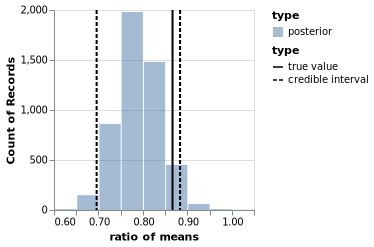

In [87]:
plot_ratios = df_ratios |>
    @vlplot(
        layer=[
        {mark={type=:bar, opacity=0.5},
         transform=[{filter="datum.type == 'posterior'"}],
         x={field=:ratio, bin=true, title="ratio of means"}, y="count()",
         color=:type},
        {mark={type=:rule, strokeWidth=2.0},
         transform=[{filter="datum.type != 'posterior'"}],
         x=:ratio, strokeDash={field=:type, scale={domain=["true value", "credible interval"]}}}
    ]
    )

In [88]:
save("figures/plot_ratio_of_means.svg", plot_ratios)